# Eval Background Bias

In [1]:
import numpy as np
import torch
import pickle
from torch.nn import functional as F
import os.path
from collections import defaultdict
from utils.misc import ablate,seed_all
from utils.factory import create_model_and_transforms, get_tokenizer
from utils.eval_utils import *
from dataset.cub_classes import place_classes
from dataset.imagenet_classes import imagenet_classes
from compute_prs import model_pretrained_dict
from utils.debias_prompt import debias_text_prompt
from utils.roboshot import *
import random
import argparse
from main_bg import *
from tqdm import tqdm
autocast = torch.cuda.amp.autocast
seed_all()
torch.set_grad_enabled(False)

/export/home2/weijie210/miniconda3/envs/clip_ltc/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/export/home2/weijie210/miniconda3/envs/clip_ltc/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
model = "ViT-H-14"
# model = "ViT-B-16"
dataset = "binary_waterbirds"
input_dir = './output_dir'

clip_model,_,preprocess = create_model_and_transforms(model,pretrained=model_pretrained_dict[model])
clip_model.to('cuda')
clip_model.eval()
tokenizer = get_tokenizer(model)
device = 'cuda'

/export/home2/weijie210/clip_text_span/utils/factory.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=map_location)

In [3]:
from dataset.binary_waterbirds import BinaryWaterbirds
root = '../imagenet'
waterbirds_ds = BinaryWaterbirds(root=f'{root}/waterbirds/waterbird_complete95_forest2water2', split='train', transform=preprocess,return_filename=False,return_spurious=True) # get spurious

# See if model can do well while predicting spurious labels
S_labels = waterbirds_ds.targets_spurious


Group 0 count: 3498
Group 1 count: 184
Group 2 count: 56
Group 3 count: 1057


In [4]:
def print_wg(gp,name_):
    if 'avg' in gp:
        avg_acc = gp.pop('avg')*100
    else:
        avg_acc = np.mean(list(gp.values()))*100
    wg = sorted(gp.values())[0]*100
    gap = avg_acc - wg
    print(f'{name_} WG/AVG/Gap: {wg:.1f} & {avg_acc:.1f} & {gap:.1f}')
    return wg,avg_acc,gap

# Load the training attn/mlp states and labels

In [5]:
attns,mlps,classifier,labels,grp_labels,grp_counts,place_label = load_bg_ds(dataset,model,input_dir)

In [6]:
val_attns,val_mlps,val_classifier,val_labels,val_grp_labels,val_grp_counts,val_place_label = load_bg_ds(dataset,model,input_dir,val=True)

# Pred the Spurious label

In [7]:
S_template = ['A photo of a bird on land background.','A photo of a bird on water background.']
# S_template = ['A photo of a bird on land surroundings.','A photo of a bird on water surroundings.']

with torch.no_grad(), autocast():
    texts = tokenizer(S_template).to(device)
    S_embeddings = clip_model.encode_text(texts)
    S_embeddings = torch.nn.functional.normalize(S_embeddings, dim=-1).T.float().detach().cpu() 

baseline_logits = ((attns.sum(axis = (1,2)) + mlps.sum(axis = 1)) @ S_embeddings).float()
S_pred = torch.argmax(baseline_logits,dim=1)

S_acc = (S_pred == S_labels).float().mean().item()
print(f'Accuracy on spurious labels: {S_acc:.2f}')

pred_grp_labels = (labels* 2 + S_pred).long()
pred_grp_counts = torch.bincount(pred_grp_labels,minlength = torch.max(pred_grp_labels)+1)
pred_grp_counts = {k:v for k,v in enumerate(pred_grp_counts)}

/tmp/ipykernel_47882/4094097451.py:4: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


Accuracy on spurious labels: 0.91


In [8]:

# val_gp = get_group_perf(attns,mlps,classifier,labels,grp_labels,grp_counts,type_ = 'val baseline')
val_gp = get_group_perf(attns,mlps,classifier,labels,pred_grp_labels,pred_grp_counts,type_ = 'val baseline') # use pred S


correct_pos,wrong_pos,baseline_pred,other_labels = get_correct_wrong(attns,mlps,classifier,labels)
biased_correct,biased_wrong = get_biased_pos(wb_biased_grps,pred_grp_labels,correct_pos,wrong_pos) 
# biased_correct,biased_wrong = get_biased_pos(wb_biased_grps,grp_labels,correct_pos,wrong_pos) 

gn_correct = get_counts(attns,mlps,baseline_pred,classifier,biased_correct,other_labels)
gn_wrong = get_counts(attns,mlps,baseline_pred,classifier,biased_wrong,other_labels)


## Finding the cls bis heads
bias_head_pos = get_impt_heads(gn_correct,gn_wrong,0.)
impt_head_pos = get_impt_heads(gn_wrong,gn_correct,0.)
print ('Bias heads:',bias_head_pos)
print ('Impt heads:',impt_head_pos)

val baseline Group 0 acc: 0.887, count: 3385
val baseline Group 1 acc: 0.343, count: 297
val baseline Group 2 acc: 0.516, count: 213
val baseline Group 3 acc: 0.921, count: 900
val baseline performance : 0.843
Val baseline performance: 84.3
Bias heads: [(30, 11), (31, 6), (31, 12)]
Impt heads: [(31, 2), (31, 13), (31, 1), (29, 9), (29, 12), (30, 8), (31, 10)]


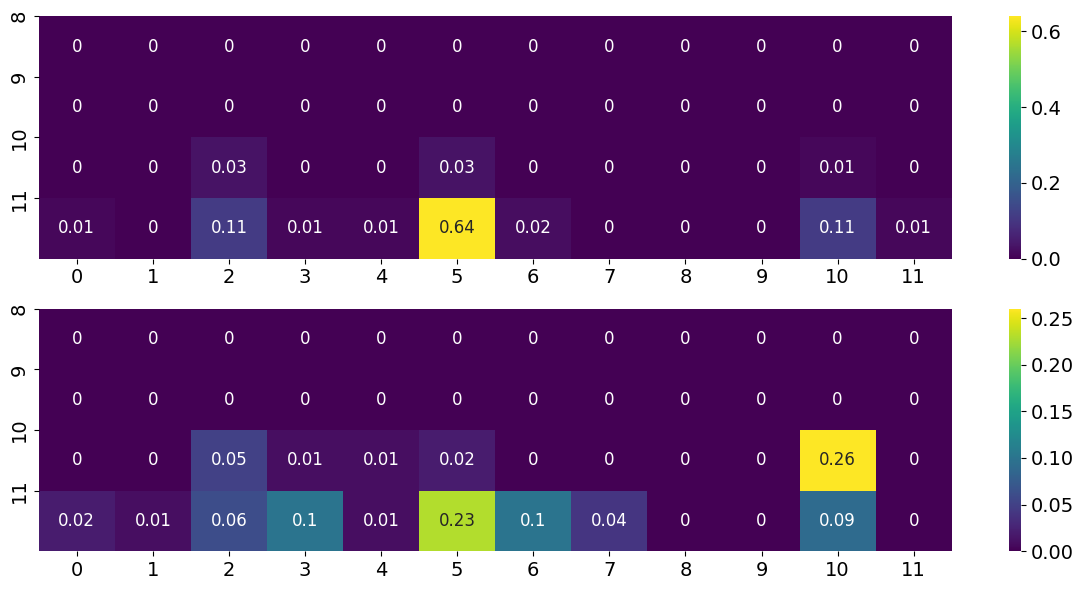

In [13]:
plot_heatmap({'correct':gn_correct.numpy(),'wrong':gn_wrong.numpy()},heads_from = 4)

In [9]:
# Load test
test_attns,test_mlps,classifier,test_labels,test_grp_labels,test_grp_counts,test_place_label = load_bg_ds(dataset,model,input_dir,test=True)

In [10]:
all_activations = {}
all_activations['Baseline'] = test_attns.sum(axis = (1,2)) + test_mlps.sum(axis = 1)
all_activations['ortho'] = test_attns.sum(axis = (1,2)) + test_mlps.sum(axis = 1)

ablated_test_attns = ablate(test_attns,bias_head_pos,type ='mean')
debiased_classifier = debias_text_prompt(clip_model,tokenizer,'cuda',classifier.T,dataset) # Debias

visual_proj = test_attns.sum(dim=(1,2)) + test_mlps.sum(dim=1)

roboshot_r = defaultdict(list)
ltc_r = defaultdict(list)

for i in range(1):
    rs_proj = rs_ortho(visual_proj,clip_model,tokenizer,dataset,accept_no=i) # roboshot
    all_activations['Roboshot'] = rs_proj
    rs_ablate_proj = ablated_test_attns.clone() # ablate bias head and roboshot
    for (l,h) in impt_head_pos:
        rs_ablate_proj[:,l,h] = rs_ortho(rs_ablate_proj[:,l,h],clip_model,tokenizer,dataset,mode = 'accept',accept_no=i)
    all_activations['LTC'] = (rs_ablate_proj.sum(dim=(1,2)) + test_mlps.sum(dim=1))

    for k,v in all_activations.items():
        class_emb = classifier if k.lower() not in ['ortho'] else debiased_classifier
        gp=get_group_perf(v,None,class_emb,test_labels.to('cpu'),test_grp_labels,test_grp_counts,type_ = k,logger=None,print_=False)
        wg,avg,gap = print_wg(gp,k)
        if k == 'Roboshot':
            roboshot_r['wg'].append(wg)
            roboshot_r['avg'].append(avg)
            roboshot_r['gap'].append(gap)
        elif k == 'LTC':
            ltc_r['wg'].append(wg)
            ltc_r['avg'].append(avg)
            ltc_r['gap'].append(gap)




Baseline WG/AVG/Gap: 50.3 & 69.5 & 19.2
ortho WG/AVG/Gap: 18.1 & 41.9 & 23.8
Roboshot WG/AVG/Gap: 60.7 & 71.6 & 10.8
LTC WG/AVG/Gap: 73.7 & 77.5 & 3.7


In [11]:
from copy import deepcopy
hidden_dim_map = {'ViT-B-16':128, 'ViT-L-14':256, 'ViT-H-14':256}
    
class Probe(torch.nn.Module):
    """
    2-layer bottleneck MLP of the form
        u  ->  ReLU(W1ᵀ u)  ->  W2ᵀ ->  scalar logit
    """
    def __init__(self, in_dim, hidden_dim = hidden_dim_map[model], *,
                 dtype: torch.dtype = torch.float32):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(in_dim, hidden_dim, bias=True, dtype=dtype),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, 1, bias=True, dtype=dtype),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x).squeeze(-1)        # ⇒ (batch,)

def train_probe(
    acts,
    labels,
    lr=1e-2,
    epochs=1,
    seed=42,
    val_acts=None,
    val_labels = None,
    val_grp_labels = None,
    bz = 64,
    weight_decay=1e-4,
    metric ='worst',
    probe = None,

):
    torch.manual_seed(seed)
    torch.set_grad_enabled(True)
    d_probe = acts.shape[-1]
    if probe is None:
        probe = Probe(d_probe).to(device)

    decay, no_decay = [], []
    for name, p in probe.named_parameters():
        if not p.requires_grad:
            continue
        (decay if p.ndim > 1 else no_decay).append(p)
    param_groups = [
        {"params": decay,     "weight_decay": weight_decay},
        {"params": no_decay,  "weight_decay": 0.0},
    ]

    optimizer = torch.optim.AdamW(param_groups, lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    best_val_metric = 0 if metric in ['worst','avg'] else 1
    best_probe = deepcopy(probe)
    

    for epoch in range(epochs):
        ## Training
        for batch_id in range(0, len(acts), bz):
            batch_acts = acts[batch_id:batch_id + bz]
            batch_labels = labels[batch_id:batch_id + bz]
            optimizer.zero_grad()
            logits = probe(batch_acts)
            
            loss = criterion(logits, batch_labels.to(logits))
            loss.backward()
            optimizer.step()

        val_epoch_acc = defaultdict(list)
        for batch_id in range(0, len(val_acts), bz):
            val_batch_acts = val_acts[batch_id:batch_id + bz]
            val_batch_labels = val_labels[batch_id:batch_id + bz]
            with torch.no_grad():
                logits_val = probe(val_batch_acts)
                pred_val = (logits_val > 0.0).long()
                val_acc = (pred_val == val_batch_labels.to(logits_val)).float().tolist()
            for gp,a in zip(val_grp_labels,val_acc):
                val_epoch_acc[gp.item()].append(a)
        for k,v in val_epoch_acc.items():
            val_epoch_acc[k] = np.mean(v)
        
        # get worst group acc
        wg = sorted(val_epoch_acc.items(),key = lambda x: x[1])[0][1]
        avg = np.mean(list(val_epoch_acc.values()))
        gap = avg - wg

        val_metric = {'worst':wg,'avg':avg,'gap':gap}[metric]
        if metric in ['worst','avg']:
            if val_metric > best_val_metric:
                best_val_metric = val_metric
                best_probe = deepcopy(probe)
        else:
            if val_metric < best_val_metric:
                best_val_metric = val_metric
                best_probe = deepcopy(probe)
            
    torch.set_grad_enabled(False)

    return best_probe, best_val_metric
    
    
@torch.no_grad()
def test_probe(
    probe,
    acts,
    labels,
    grp_labels= None,
    bz = 64,
):
    grp_acc = defaultdict(list)
    mean_acc = []
    for batch_id in range(0, len(acts), bz):
        batch_acts = acts[batch_id:batch_id + bz]
        batch_labels = labels[batch_id:batch_id + bz]
        batch_grp_labels = grp_labels[batch_id:batch_id + bz]

        logits = probe(batch_acts)
        preds = (logits > 0.0).long()
        acc = (preds == batch_labels.to(preds)).float()
        mean_acc.append(acc.mean().item())
        for g,a in zip(batch_grp_labels,acc):
            grp_acc[g.item()].append(a.item())
            
    for k,v in grp_acc.items():
        grp_acc[k] = np.mean(v)
    return mean_acc, grp_acc



In [12]:
def repeat_group_samples(grp_labels,acts,labels,worst_grp,upsample):
    upsampled_acts = []
    upsampled_labels = []
    for grp_label,act,label in zip(grp_labels,acts,labels):
        if grp_label.item() in worst_grp:
            upsampled_acts.append(act.unsqueeze(0).repeat(upsample,1))
            upsampled_labels.append(label.unsqueeze(0).repeat(upsample))
        else:
            upsampled_acts.append(act.unsqueeze(0))
            upsampled_labels.append(label.unsqueeze(0))
    upsampled_acts = torch.cat(upsampled_acts,dim=0)
    upsampled_labels = torch.cat(upsampled_labels,dim=0)
    perm = torch.randperm(len(upsampled_acts))
    return upsampled_acts[perm], upsampled_labels[perm]

def get_ltc_repr(attns,mlps,bias_head=None,impt_head=None):
    cloned_attns = attns.clone()
    if bias_head is not None:
        cloned_attns = ablate(cloned_attns,bias_head)
    if impt_head is not None:
        for (l,h) in impt_head:
            cloned_attns[:,l,h] = rs_ortho(cloned_attns[:,l,h],clip_model,tokenizer,dataset,mode = 'accept')
    return (cloned_attns.sum(axis = (1,2)) + mlps.sum(axis = 1)).to(device)

    

In [13]:
train_img_repr = (attns.sum(axis = (1,2)) + mlps.sum(axis = 1)).to(device)
train_labels = labels.to(device)

val_img_repr = (val_attns.sum(axis = (1,2)) + val_mlps.sum(axis = 1)).to(device)
val_labels = val_labels.to(device)

test_img_repr = (test_attns.sum(axis = (1,2)) + test_mlps.sum(axis = 1)).to(device)
test_labels = test_labels.to(device)

# Train ERM probe

In [14]:
# HP
lr = 1e-2
wd = 1e-4
G_N = [1,2]
bz = 64
total_epochs = 100
upsample = 90 if model == 'ViT-H-14' else 100


In [15]:
erm_probe,_, = train_probe(train_img_repr,train_labels,epochs = total_epochs,lr = lr,weight_decay = wd,val_acts = val_img_repr,val_labels = val_labels,val_grp_labels=val_grp_labels,bz = bz)
erm_mean_acc,erm_grp_acc = test_probe(erm_probe,test_img_repr,test_labels,test_grp_labels,bz = bz)
_,_,_ = print_wg(erm_grp_acc,f'ERM')

ERM WG/AVG/Gap: 56.2 & 85.2 & 29.0


# JTT

In [16]:

erm_train_repr,erm_train_labels = repeat_group_samples(pred_grp_labels,train_img_repr,train_labels,G_N,upsample=upsample)

erm_probe,erm_val_acc, = train_probe(erm_train_repr,erm_train_labels,epochs = total_epochs,lr = lr,weight_decay = wd,val_acts = val_img_repr,val_labels = val_labels,val_grp_labels=val_grp_labels,bz = bz)

erm_mean_acc,erm_grp_acc = test_probe(erm_probe,test_img_repr,test_labels,test_grp_labels,bz = bz)
_,_,_ = print_wg(erm_grp_acc,f'JTT')

JTT WG/AVG/Gap: 85.7 & 91.4 & 5.8


# JTT + LTC

In [17]:
ltc_test_repr = get_ltc_repr(test_attns,test_mlps,bias_head = bias_head_pos,impt_head = impt_head_pos)
erm_mean_acc,erm_grp_acc = test_probe(erm_probe,ltc_test_repr,test_labels,test_grp_labels,bz = 64,)
_,_,_ = print_wg(erm_grp_acc,f'JTT + LTC')

JTT + LTC WG/AVG/Gap: 87.2 & 93.4 & 6.2
